## Model Analysis

In [13]:
from importlib import reload
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from model import Transformer, TransformerConfig
import data
import config
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def setup_plot_style():
    # Reset to default style
    plt.style.use('default')
    
    # Make background white
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['figure.facecolor'] = 'white'
    
    # Remove gridlines
    plt.rcParams['axes.grid'] = False
    
    # Make font black and serif
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    
    # Remove top and right spines
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
     
    # Increase x and y axis label size
    plt.rcParams['axes.labelsize'] = 12


# Call this function before creating your plots
setup_plot_style()

In [23]:
# Load the CSV file
# df = pd.read_csv('/home/neil/proj/stress_strain/results/results_20240721_155627.csv')  # sweep all (LR bug)
# df = pd.read_csv('/home/neil/proj/stress_strain/results/results_20240721_163240.csv')  # LR sweep
# df = pd.read_csv('/home/neil/proj/stress_strain/results/20240722_115643/all_results.csv')  # depth sweep
df = pd.read_csv('/home/neil/proj/stress_strain/results/20240722_163518/all_results.csv')  # depth sweep

 
print(f"Loaded {len(df)} rows of data.")

Loaded 15 rows of data.


## 1. Best Hyperparameters

In [24]:
# Find the row with the lowest eval_loss
best_row = df.loc[df['eval_loss'].idxmin()]

# Print the best hyperparameters and corresponding metrics
print("Best Hyperparameters:")
hyperparams = ['train_size', 'num_layers', 'hidden_dim', 'learning_rate', 'dropout_rate', 'total_examples']
for param in hyperparams:
    print(f"{param}: {best_row[param]}")

print(f"\nBest Evaluation Loss: {best_row['eval_loss']:.4f}")
print(f"Step: {best_row['step']}")
print(f"Training Loss: {best_row['train_loss']:.4f}")

Best Hyperparameters:
train_size: 168
num_layers: 6
hidden_dim: 16
learning_rate: 0.01
dropout_rate: 0.0
total_examples: 100000

Best Evaluation Loss: 0.0024
Step: 6000
Training Loss: 0.0005


## 2. Hyperparameter Impact Plots

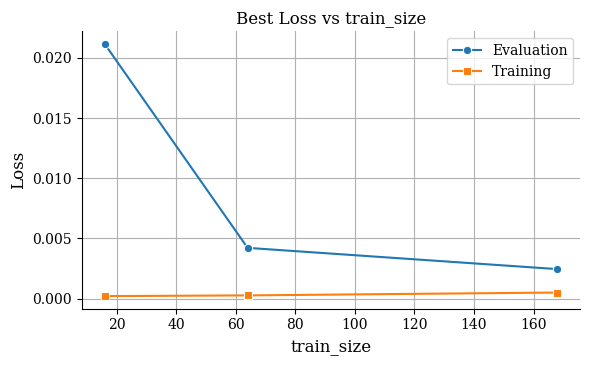

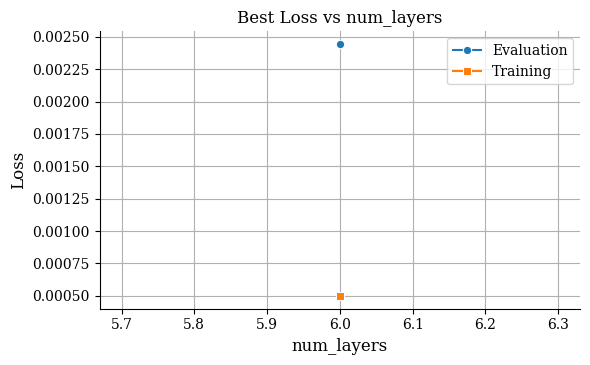

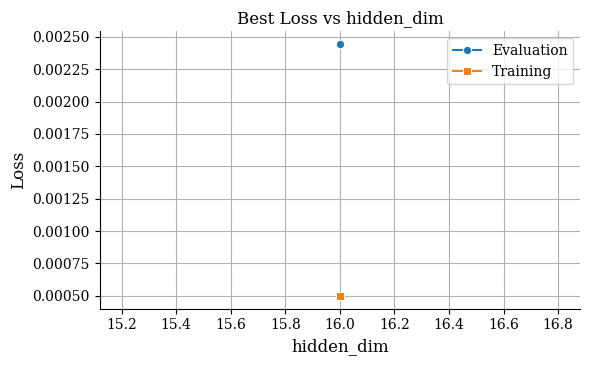

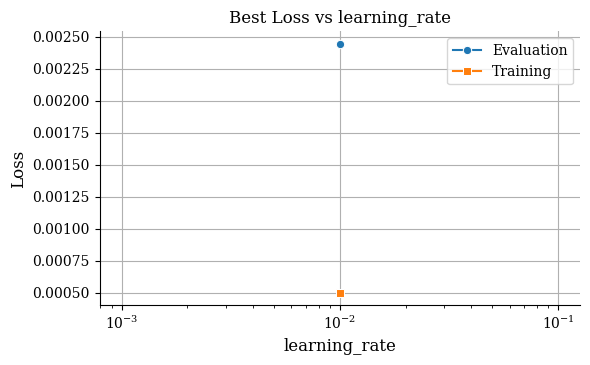

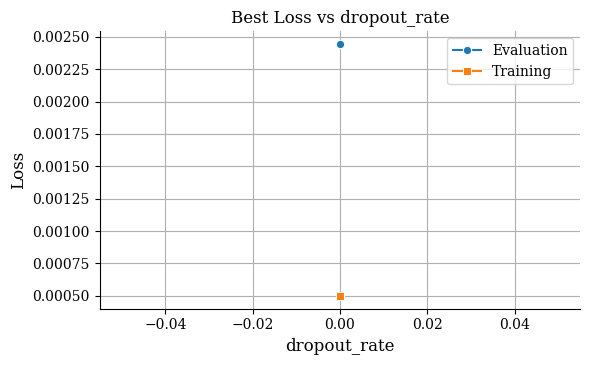

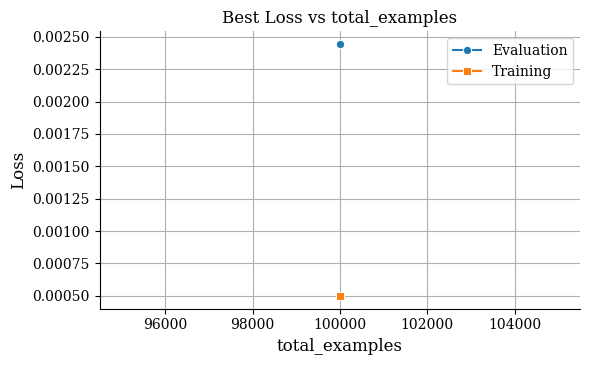

In [26]:
def plot_hyperparam_impact(df, param, plot_training_loss=False):
    # Group by the hyperparameter and find the best eval_loss and corresponding train_loss for each value
    grouped_eval = df.groupby(param)['eval_loss'].min().reset_index()
    grouped_train = df.loc[df.groupby(param)['eval_loss'].idxmin()].reset_index()
   
    plt.figure(figsize=(6, 6/1.6))
    
    # Plot evaluation loss
    sns.lineplot(x=param, y='eval_loss', data=grouped_eval, marker='o', label='Evaluation')
    
    if plot_training_loss:
        # Plot training loss
        sns.lineplot(x=param, y='train_loss', data=grouped_train, marker='s', label='Training')
    
    plt.title(f'Best Loss vs {param}')
    plt.xlabel(param)
    plt.ylabel('Loss')
    if param == 'learning_rate':
        plt.xscale('log')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for each hyperparameter
for param in hyperparams:
    plot_hyperparam_impact(df, param, True)

## 4. Run inference and plot

Plots saved to /home/neil/proj/stress_strain/train_predictions.pdf
Plots saved to /home/neil/proj/stress_strain/test_predictions.pdf


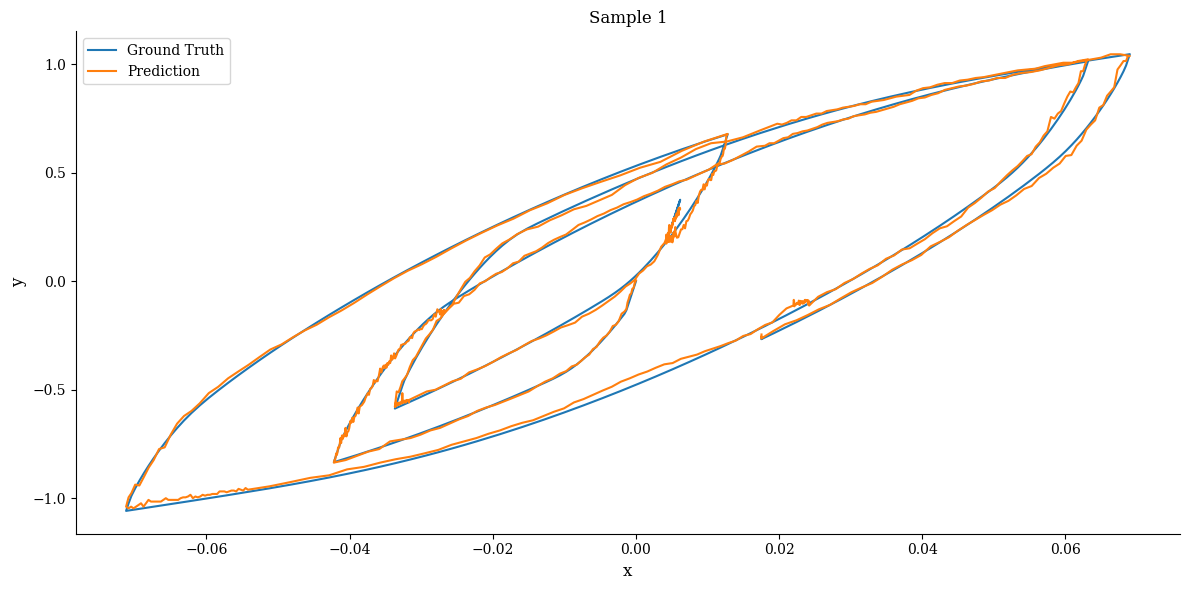

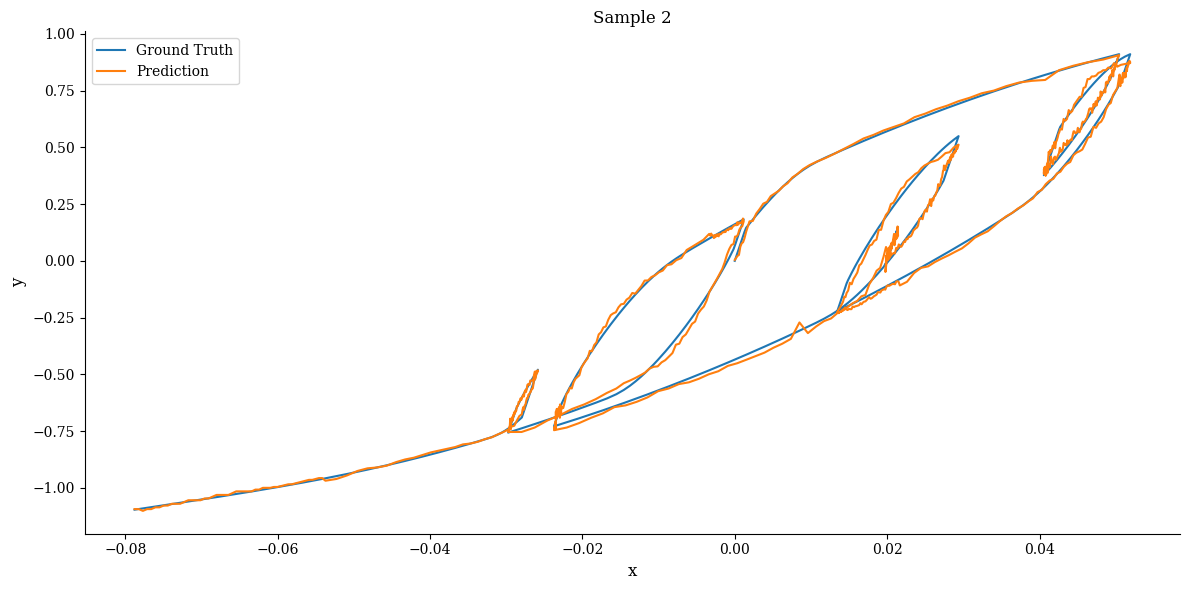

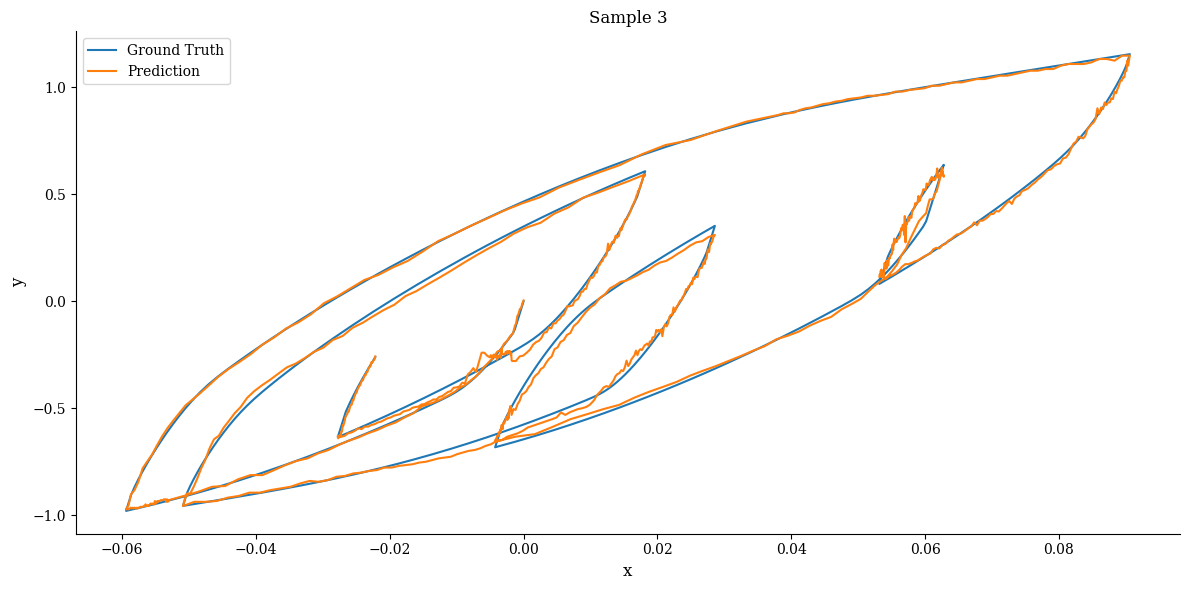

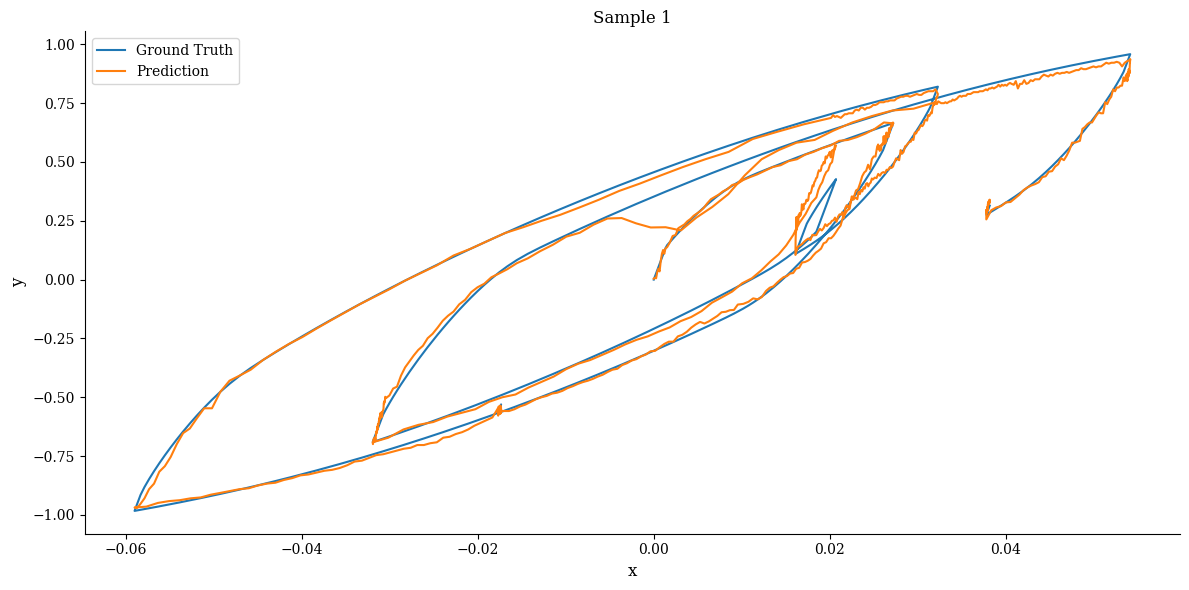

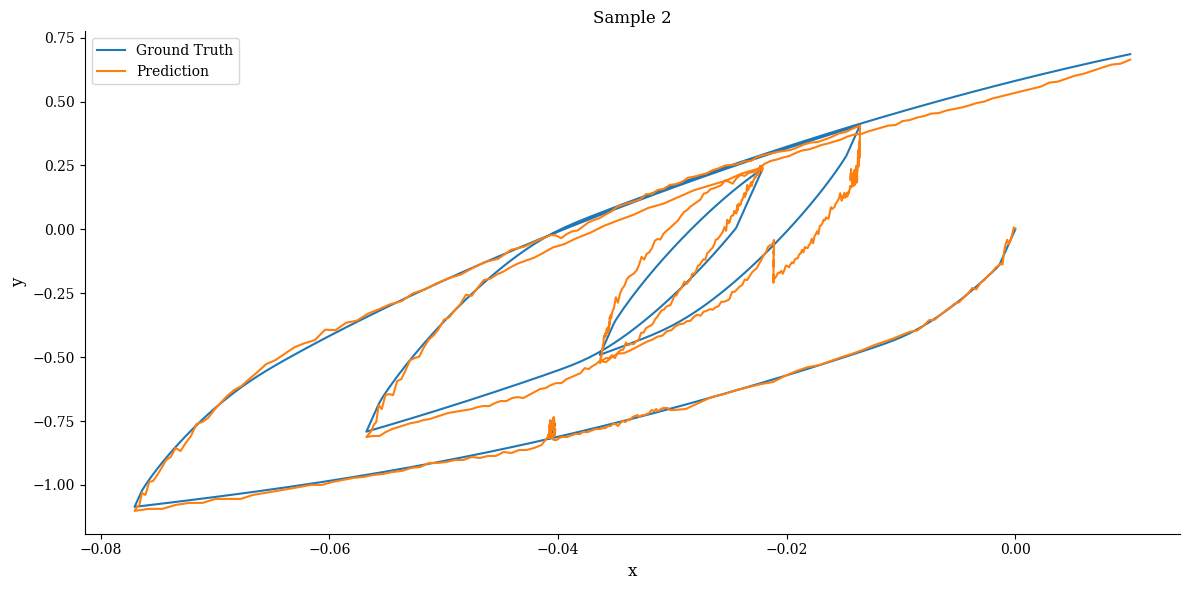

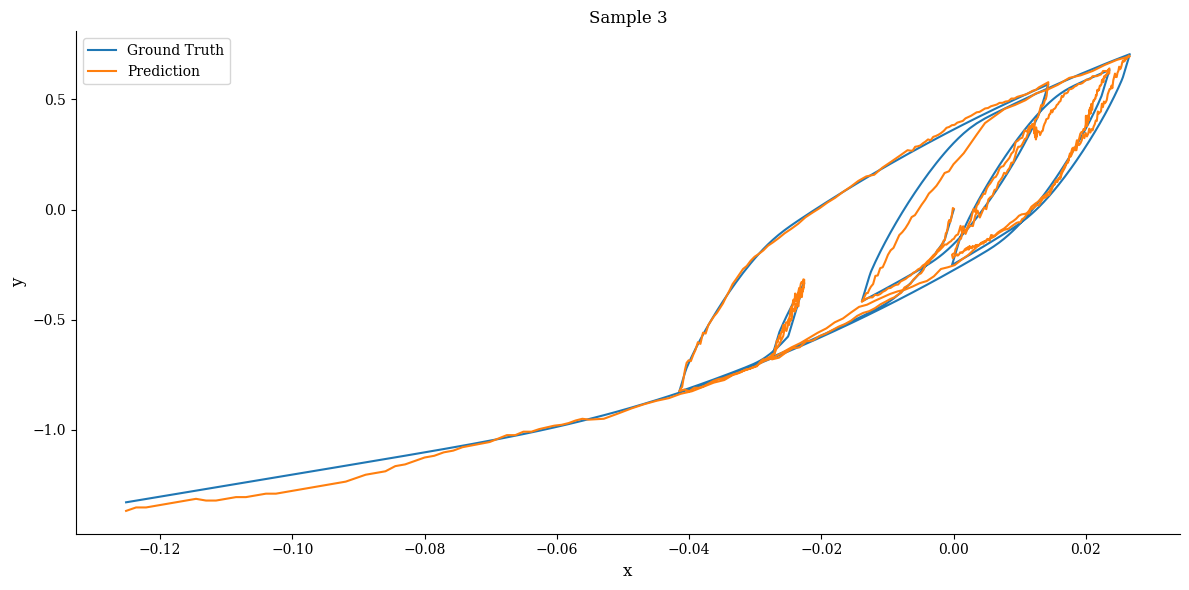

In [39]:
config = reload(config)

def load_model(checkpoint_path):
    # Create a TransformerConfig object with the same parameters as used during training
    model_cfg = TransformerConfig(
        max_len=config.base_hparams["max_len"],
        num_layers=config.base_hparams["num_layers"],
        hidden_dim=config.base_hparams["hidden_dim"],
        mlp_dim=config.base_hparams["mlp_dim"],
        num_heads=config.base_hparams["num_heads"],
        dropout_rate=config.base_hparams["dropout_rate"],
        attention_dropout_rate=config.base_hparams["attention_dropout_rate"],
        causal_x=config.base_hparams["causal_x"],
        physics_decoder=config.base_hparams["physics_decoder"],
    )
    
    # Create the model
    model = Transformer(model_cfg)
    
    # Load the checkpoint
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))['model_state_dict']
    # Remove the '_orig_mod.' prefix from keys
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            new_state_dict[k[10:]] = v  # Remove first 10 characters ('_orig_mod.')
        else:
            new_state_dict[k] = v
    model.load_state_dict(new_state_dict)
    
    return model

def run_inference(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_x = []
    all_predictions = []
    all_ground_truth = []
    
    with torch.no_grad():
        for batch in test_loader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                predictions, _, _ = model({'x': x})
            predictions = predictions.to(torch.float32)


            
            all_x.append(x.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            all_ground_truth.append(y.cpu().numpy())
    
    return np.concatenate(all_x), np.concatenate(all_predictions), np.concatenate(all_ground_truth)


def plot_predictions(x, predictions, ground_truth, num_samples=3, filename='predictions.pdf'):
    figs = []
    with PdfPages(filename) as pdf:
        for i in range(num_samples):
            fig, ax = plt.subplots(figsize=(12, 6))
            
            ax.plot(x[i, :, 0], ground_truth[i, :, 0], label='Ground Truth')
            ax.plot(x[i, :, 0], predictions[i, :, 0], label='Prediction')
            ax.set_title(f'Sample {i+1}')
            ax.legend()
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            
            plt.tight_layout()
            pdf.savefig(fig)
            figs.append(fig)
    
    print(f"Plots saved to {filename}")
    return figs


torch.set_float32_matmul_precision("high")

# Load the checkpoint
checkpoint_path = "/home/neil/proj/stress_strain/results/20240722_170719/1/model.pth"
model = load_model(checkpoint_path)
    
# Get the test dataset
train_loader, test_loader = data.get_datasets(batch_size=config.base_hparams["batch_size"], train_size=16)

# Run inference on train set
train_x, train_predictions, train_ground_truth = run_inference(model, train_loader)
train_figs = plot_predictions(train_x, train_predictions, train_ground_truth, filename='/home/neil/proj/stress_strain/train_predictions.pdf')
    
# Run inference on test set
test_x, test_predictions, test_ground_truth = run_inference(model, test_loader)
test_figs = plot_predictions(test_x, test_predictions, test_ground_truth, filename='/home/neil/proj/stress_strain/test_predictions.pdf')

for fig in train_figs:
    plt.show()
    
for fig in test_figs:
    plt.show()

In [19]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

MAX_LEN = 1001
TEST_SIZE = 32
TRAIN_SIZE = 200 - TEST_SIZE
DATA_PATH = "data.npz"

class DictDataset(Dataset):
    def __init__(self, dictionary):
        self.dictionary = dictionary

    def __getitem__(self, index):
        return {key: values[index] for key, values in self.dictionary.items()}

    def __len__(self):
        return len(next(iter(self.dictionary.values())))

def get_datasets(
    batch_size,
    max_len=MAX_LEN,
    train_size=TRAIN_SIZE,
    test_size=TEST_SIZE,
):
    with open(DATA_PATH, "rb") as f:
        data = np.load(f)
        RAW_DATA = data["arr_0"]

    data = RAW_DATA[:, :max_len, :]
    dummy_x =  torch.rand(*data[:train_size, :max_len, 0][..., None].shape)
    dummy_y =  torch.rand(*data[:train_size, :max_len, 0][..., None].shape)
    train_x = torch.FloatTensor(data[:train_size, :max_len, 0][..., None])
    train_y = torch.FloatTensor(data[:train_size, :max_len, 1][..., None])
    test_x = torch.FloatTensor(data[-test_size:, :max_len, 0][..., None])
    test_y = torch.FloatTensor(data[-test_size:, :max_len, 1][..., None])

    train_ds = DictDataset({"x": train_x, "y": train_y})
    test_ds = DictDataset({"x": test_x, "y": test_y})

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [20]:
tr, te = get_datasets(1)

In [21]:
te